# Segmentando clientes

En esta notebook se verá una forma sobre como segmentar a los clientes, cuando cuenta con una gran cantidad de estos sobre una base de datos de una gran (?) cantidad de dimensiones.

Empezaremos cargando el entorno e instalando los requerimentos necesarios.

In [1]:
#%pip install scikit-learn==1.3.2
#%pip install seaborn==0.13.1
#%pip install numpy==1.26.4
#%pip install matplotlib==3.7.1
# %pip install umap
# %pip install umap-learn
# %pip install pyarrow

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.ensemble import  RandomForestClassifier
from sklearn.impute import SimpleImputer

In [3]:
base_path = '../'
dataset_path = base_path + 'datasets/'
modelos_path = base_path + 'modelos/'
db_path = base_path + 'db/'
dataset_file = 'competencia_01_imp_nulos_04.parquet'

In [4]:
df_train = pd.read_parquet(dataset_path + dataset_file)


Solo segmentaremos a los clientes de abril, dado que necesitaremos variables en algún momento agregar variables históricas para entender su comportamiento previo a la **baja**

In [5]:
df_train = df_train[df_train['foto_mes' ]==202104]

A su vez, nos concentraremos en el fenómeno de la **baja**. No importa si es en un mes o si es en dos.

In [6]:
Xtrain = df_train
ytrain = Xtrain["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)
Xtrain = Xtrain.drop("clase_ternaria", axis=1)

del(df_train)

Lo primero que necesitamos es saber cuando un cliente es parecido a otro. Todos los clientes que son parecidos los juntaremos en un **segmento** y sobre esos segmentos haremos perfilados o profiles para entender que los caracteriza.

Saber cuando un cliente es parecido a otro no es algo tan simple en un problema de alta dimensionalidad, lo que se suele llamar **curse of dimensionality**. Las cosas no son lo mismo más allá de nuestras 3 escasas dimensiones. Para muestra, un botón: https://www.youtube.com/watch?v=mceaM2_zQd8

Por esto, es conveniente usar herramientas que nos ayuden a no tener que hacer distancias euclídeas.

Empecemos con una ayuda con nos dan nuestros amigos, los **rf** con una original matriz de distancias (https://en.wikipedia.org/wiki/Distance_matrix)

La **Random Forest Distance** es una matriz derivada del algoritmo Random Forest,

+ Se utiliza para medir la similitud entre pares de puntos de datos. Esta métrica se basa en la idea de cuántas veces dos puntos de datos terminan en la misma hoja de un árbol en un **rf**, entre los múltiples árboles que se generan.

+ Cómo se Calcula?

 1. Se entrena un **rf**.
 2. Para cada par de clientes $c_i$ y $c_j$, se observa cuántas veces caen en la misma hoja a través de todos los árboles del bosque. Luego se agrega en la posición $i$, $j$ de una matriz el número de veces que coincidieron esos dos clientes en un nodo terminal.
 3. Se calcula la matriz de distancia como **1 - proporción de veces que caen en la misma hoja**. Ejemplo: Si caen en la misma hoja el 90% de las veces, su distancia será 0.1. Si nunca caen en la misma hoja, la distancia es 1.

Veamoslo aplicado en nuestro caso

Para trabajar con este algoritmo no vamos a trabajar con todos los datos. Usted decida con cuantos trabajar. En este caso, tomaremos todos los **baja** y unos 2000 **continua**, ya que queremos como interactuan los segmentos de clientes que se van con los que se quedan.


In [7]:
np.random.seed(17)
continua_sample = ytrain[ytrain == 0].sample(2000).index
bajas_1_2 = ytrain[ytrain == 1].index
rf_index = continua_sample.union(bajas_1_2)

Xtrain_rf = Xtrain.loc[rf_index]
ytrain_rf = ytrain.loc[rf_index]

In [8]:
# get rows with na in Xtrain
na_rows = Xtrain_rf[Xtrain_rf.isna().any(axis=1)].index
# get column names with na
na_columns = Xtrain_rf.columns[Xtrain_rf.isna().any()].tolist()
Xtrain_rf.loc[na_rows, ['numero_de_cliente','foto_mes'] + na_columns]

,numero_de_cliente,foto_mes


Entrenamos un simple **rf**, despliegue sus herramientas aprendidas para contar con un buen modelo


In [9]:
max_float32 = np.finfo(np.float32).max
max_float32

3.4028235e+38

In [10]:
# check if any column has values greater than max_float32
cols_too_large = Xtrain_rf.columns[(abs(Xtrain_rf) > max_float32).any()].to_list()

In [11]:
for i in cols_too_large:
    # replace values greater than max_float32 with max_float32
    Xtrain_rf[i] = Xtrain_rf[i].clip(-max_float32, max_float32)

In [12]:
# Assuming your data is in a DataFrame called df
print(Xtrain_rf.isna().sum())  # Check for NaN values
print(np.isinf(Xtrain_rf).sum()) 

mcuentas_saldo            0
mpayroll                  0
mpayroll2                 0
mforex_sell               0
mforex_buy                0
                         ..
lag1_total_msaldototal    0
lag1_total_patrimonio     0
lag1_total_payroll        0
lag1_total_prestamos      0
cumpleanios               0
Length: 690, dtype: int64
mcuentas_saldo            0
mpayroll                  0
mpayroll2                 0
mforex_sell               0
mforex_buy                0
                         ..
lag1_total_msaldototal    0
lag1_total_patrimonio     0
lag1_total_payroll        0
lag1_total_prestamos      0
cumpleanios               0
Length: 690, dtype: int64


In [13]:
# imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
# Xtrain_rf_imp = imp_mean.fit_transform(Xtrain_rf)
import os
from dotenv import load_dotenv
import urllib

# read env
load_dotenv()

# insertar codigo de optuna para hallar hp adecuados
storage_name = "mysql+mysqldb://{u}:{p}@{ip}:3306/optuna_rf_db".format(p=urllib.parse.quote_plus(os.getenv("password")), u = os.getenv("usersrv"), ip = os.getenv("ip"))





In [14]:
from sklearn.metrics import roc_auc_score


def objective(trial):
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 500)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 500)
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_features = trial.suggest_float('max_features', 0.05, 0.8)
    max_samples = trial.suggest_float('max_samples', 0.2, 0.8)
    
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        max_samples= max_samples,
        random_state=semillas[0],
        n_jobs=-1,
        oob_score=True
    )

    model.fit(Xtrain_rf, ytrain_rf)

    return roc_auc_score(model.predict(Xtrain_rf), ytrain_rf, average='weighted')



In [15]:
import optuna

study_name = "rf-segmentacion"

# study = optuna.create_study(
#     direction="maximize",
#     study_name=study_name,
#     storage=storage_name,
#     load_if_exists=True,
# )



In [16]:
semillas = [549937, 792991, 886969, 208961, 780587]

In [17]:

# study.optimize(objective, n_trials=50)

Armamos (copiamos de internet) una función que nos calcule la matriz de distancias

In [18]:
study = optuna.load_study(
    study_name=study_name,
    storage=storage_name
)



In [19]:
model_rf = RandomForestClassifier(
        **study.best_params,
        random_state=semillas[0],
        n_jobs=-1,
        oob_score=True
    )

In [20]:
model_rf.fit(Xtrain_rf, ytrain_rf)


c:\Users\jgjua\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


RandomForestClassifier(max_depth=32, max_features=0.5506750193083555,
                       max_samples=0.7880396295164841, min_samples_leaf=2,
                       min_samples_split=58, n_estimators=191, n_jobs=-1,
                       oob_score=True, random_state=549937)

In [21]:
def distanceMatrix(model, X):
    """
    Calculates the distance matrix based on the given model and input data.

    Parameters:
    model (object): The model used to calculate the terminals.
    X (array-like): The input data.

    Returns:
    array-like: The distance matrix.
    """

    terminals = model.apply(X)
    # a 2D array where each column corresponds to a tree in the model and each row corresponds to a data point
    nTrees = terminals.shape[1]

    a = terminals[:,0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[:,i]
        proxMat += 1*np.equal.outer(a, a)

    proxMat = proxMat / nTrees

    return proxMat.max() - proxMat

md = distanceMatrix(model_rf, Xtrain_rf)

c:\Users\jgjua\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Veamos como se ve. Recuerde que significa que un número esté cerca de 0 o que esté cerca de 1.

In [22]:
# md

Para poder visualizar la matriz, utilizaremos un embedding. Los *embeddings* son representaciones vectoriales de datos en un espacio de menor dimensión

Podría utilizar un **PCA** con ese fin, pero en los últimos años hay mejores algoritmos como **t-sne** o **umap**.

UMAP (Uniform Manifold Approximation and Projection) es una técnica avanzada para la reducción de dimensionalidad y visualización de datos en espacios de menor dimensión, que busca mantener al máximo la estructura de los datos en alta dimensión.

1. **Preservación de la Estructura Global y Local**:
   - Intenta preservar tanto la estructura local (relaciones cercanas) como la global (estructura general) de los datos al proyectarlos en un espacio de menor dimensión.

2. **Basado en Manifold Learning**:
   - UMAP asume que los datos de alta dimensión se encuentran en un espacio de menor dimensión (un "manifold") y busca proyectar esos datos de manera que se mantenga esa estructura subyacente.

3. **Velocidad y Escalabilidad**:
   - UMAP es más rápido y escalable en comparación con técnicas similares como t-SNE, especialmente en conjuntos de datos grandes.

4. **Control sobre la Estructura**:
   - UMAP permite al usuario ajustar parámetros que controlan la preservación de la estructura local y global, como el número de vecinos cercanos (n_neighbors) y la distancia mínima entre puntos (min_dist).

Una característica adicional, es que cuenta con la posibilidad de recibir de entrada una matriz de distancia.

Veamos los datos por primera vez:

In [23]:
class_index = np.where(model_rf.classes_ == 1)[0]
prob_baja = model_rf.predict_proba(Xtrain_rf)[:,class_index]

c:\Users\jgjua\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


c:\Users\jgjua\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1858: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
c:\Users\jgjua\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


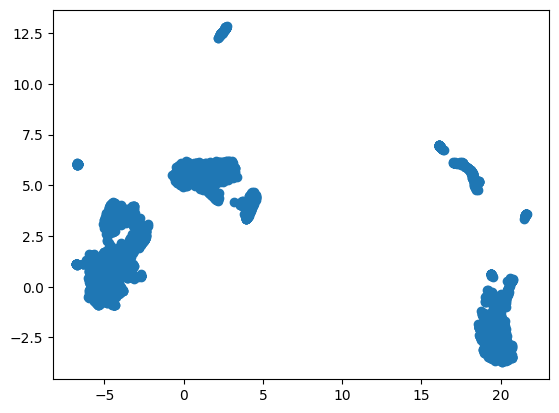

In [24]:
embedding_rf = UMAP(
  n_components=2,
  n_neighbors=100,
  metric="precomputed",
  random_state=17,
  learning_rate=0.3
).fit_transform(md)

plt.scatter(embedding_rf[:,0], embedding_rf[:,1])

In [25]:
import plotly.express as px

df = pd.DataFrame(embedding_rf, columns=["x", "y"])
df["prob_baja"] = pd.cut(np.ravel(prob_baja), bins=4, labels=False).astype(str)
fig = px.scatter(df, x='x', y='y', color='prob_baja')
fig.show()

Agreguemos la dimensión de la probabilidad de salida, para ver donde cree el modelo que se encuentran los **bajas**.

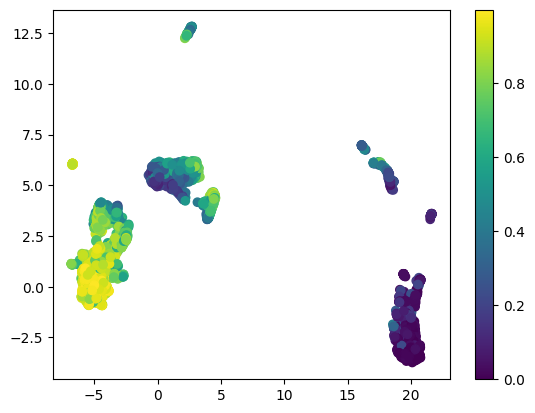

In [26]:


plt.scatter(embedding_rf[:,0], embedding_rf[:,1], c=prob_baja)
plt.colorbar()
plt.show()

Vamos a partir de este embedding para segmentar a los clientes. Puede utilizar cualquier técnica, los datos ya son simples para cualquier algoritmo. Utilizaremos uno bastante estandar

In [27]:
hdb = DBSCAN(eps=0.6)
y = hdb.fit(embedding_rf)



In [28]:
import plotly.express as px

df = pd.DataFrame(embedding_rf, columns=["x", "y"])
df["cluster"] = y.labels_.astype(str)
fig = px.scatter(df, x='x', y='y', color='cluster')
fig.show()

Veamos cuantos cluster detecto y cuantos clientes tiene cada uno

Los que tienen -1, son considerados outliers.

Por último necesitamos alguna forma de saber que hace a cada cluster distinto del otro. Para esto utilizaremos modelos (**rf**) que buscan separar los cluster uno a uno del resto de los datos.

Por cada modelo, miraremos cuales son las variables más importantes que separan los datos para luego caracterizarlos:

Manos a la obra:

In [29]:
df_embedding = pd.DataFrame(embedding_rf, columns=['embedding_1', 'embedding_2'])
df_embedding['cluster'] = y.labels_

clusters = df_embedding['cluster'].unique()

important_features_by_cluster = {}


def objective2(trial):
    max_depth = trial.suggest_int('max_depth', 2, 24)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 100)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 100)
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_features = trial.suggest_float('max_features', 0.1, 0.8)
    max_samples = trial.suggest_float('max_samples', 0.2, 0.8)
    
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        max_samples= max_samples,
        random_state=semillas[0],
        n_jobs=-1,
        oob_score=True
    )

    model.fit(Xtrain_rf, ytrain_rf)

    return roc_auc_score(model.predict(Xtrain_rf), ytrain_rf, average='weighted')




In [30]:
clusters

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [31]:
mean_prob_baja_by_cluster = {}

for cluster in clusters:
    cluster_indices = np.where(y.labels_ == cluster)[0]
    prob_baja_cluster = prob_baja[cluster_indices]
    mean_prob_baja = np.mean(prob_baja_cluster)
    mean_prob_baja_by_cluster[cluster] = mean_prob_baja

mean_prob_baja_by_cluster

{0: 0.3688260999608778,
 1: 0.04051574994109975,
 2: 0.8665568799245215,
 3: 0.6799490235879697,
 4: 0.5384338546306148,
 5: 0.3095543593124713,
 6: 0.1012866156373002,
 7: 0.9369656831939353,
 8: 0.37652068763277485,
 9: 0.027474040770264996}

In [32]:

for cluster in clusters:
  y_binary = (df_embedding['cluster'] == cluster).astype(int)

  study_name = "rf-segmentacion-{cluster}".format(cluster=cluster)


  study = optuna.create_study(
         direction="maximize",
         study_name=study_name,
         storage=storage_name,
         load_if_exists=True,
  )
  
  if len(study.trials) < 20:
    study.optimize(objective2, n_trials=20)
  
  
  model = RandomForestClassifier(
        **study.best_params,
        random_state=semillas[0],
        n_jobs=-1,
        oob_score=True
    )

  model.fit(Xtrain_rf, y_binary)

  importances = model.feature_importances_
  feature_names = Xtrain_rf.columns

  indices = np.argsort(importances)[::-1]

  
  important_features_by_cluster[cluster] = [feature_names[i] for i in indices]
  print("Cluster {cluster} resuelto".format(cluster=cluster))

[I 2024-09-20 09:36:40,762] Using an existing study with name 'rf-segmentacion-0' instead of creating a new one.
c:\Users\jgjua\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning:

invalid value encountered in reduce



Cluster 0 resuelto


[I 2024-09-20 09:36:54,449] Using an existing study with name 'rf-segmentacion-1' instead of creating a new one.
c:\Users\jgjua\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning:

invalid value encountered in reduce



Cluster 1 resuelto


[I 2024-09-20 09:37:09,630] Using an existing study with name 'rf-segmentacion-2' instead of creating a new one.
c:\Users\jgjua\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning:

invalid value encountered in reduce



Cluster 2 resuelto


[I 2024-09-20 09:37:27,775] Using an existing study with name 'rf-segmentacion-3' instead of creating a new one.
c:\Users\jgjua\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning:

invalid value encountered in reduce



Cluster 3 resuelto


[I 2024-09-20 09:37:32,987] Using an existing study with name 'rf-segmentacion-4' instead of creating a new one.
c:\Users\jgjua\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning:

invalid value encountered in reduce



Cluster 4 resuelto


[I 2024-09-20 09:37:42,206] Using an existing study with name 'rf-segmentacion-5' instead of creating a new one.
c:\Users\jgjua\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning:

invalid value encountered in reduce



Cluster 5 resuelto


[I 2024-09-20 09:37:47,917] Using an existing study with name 'rf-segmentacion-6' instead of creating a new one.
c:\Users\jgjua\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning:

invalid value encountered in reduce



Cluster 6 resuelto


[I 2024-09-20 09:37:59,255] Using an existing study with name 'rf-segmentacion-7' instead of creating a new one.
c:\Users\jgjua\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning:

invalid value encountered in reduce



Cluster 7 resuelto


[I 2024-09-20 09:38:05,030] Using an existing study with name 'rf-segmentacion-8' instead of creating a new one.
c:\Users\jgjua\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning:

invalid value encountered in reduce



Cluster 8 resuelto


[I 2024-09-20 09:38:17,838] Using an existing study with name 'rf-segmentacion-9' instead of creating a new one.
c:\Users\jgjua\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning:

invalid value encountered in reduce



Cluster 9 resuelto


Y exploramos cuales son las variables importantes por cada cluster

In [33]:
for cluster, features in important_features_by_cluster.items():

  p = mean_prob_baja_by_cluster[cluster].round(3)
  print(f"Cluster {cluster} (p = {p}, q = {np.sum(y.labels_ == cluster)}) vs. Resto:")
  for feature in features[:5]:
    print(f"  - {feature}")


Cluster 0 (p = 0.369, q = 886) vs. Resto:
  - ctrx_quarter
  - total_payroll
  - cpayroll_trx
  - mtarjeta_visa_consumo
  - lag1_ctrx_quarter
Cluster 1 (p = 0.041, q = 933) vs. Resto:
  - mpayroll
  - total_payroll
  - cpayroll_trx
  - ctrx_quarter
  - variacion_decil_Master_mconsumosdolares
Cluster 2 (p = 0.867, q = 1725) vs. Resto:
  - ctrx_quarter
  - lag1_ctrx_quarter
  - mpayroll
  - mprestamos_personales
  - variacion_decil_matm_other
Cluster 3 (p = 0.68, q = 209) vs. Resto:
  - ctrx_quarter
  - total_payroll
  - cpayroll_trx
  - lag1_ctrx_quarter
  - mpayroll
Cluster 4 (p = 0.538, q = 98) vs. Resto:
  - ctrx_quarter
  - lag1_ctrx_quarter
  - mprestamos_personales
  - lag1_mprestamos_personales
  - decil_mprestamos_personales
Cluster 5 (p = 0.31, q = 162) vs. Resto:
  - ctrx_quarter
  - lag1_ctrx_quarter
  - variacion_mpayroll
  - mpayroll
  - mcomisiones_mantenimiento
Cluster 6 (p = 0.101, q = 38) vs. Resto:
  - variacion_decil_Master_mconsumosdolares
  - mpayroll
  - lag1_mpayr

Luego resta, analizar los estadísticos de los datos de cada cluster para las variables importantes, comparar sus distribuciones con histogramas, boxplots, pivot tables, etc.


Junto con el diccionaro de datos, de sentido a lo que ve a través del análisis multivariado de datos.

Obviamente, esto es apenas mas que una semilla. Agregue las variables históricas, juegue con los **rf** y genere una segmentación pro, que encante a Miranda


In [37]:
df_clusters = Xtrain_rf.copy()

In [38]:
df_clusters['cluster'] = y.labels_

In [51]:
y.labels_

array([0, 1, 0, ..., 5, 2, 0], dtype=int64)

In [39]:
df_clusters['clase'] = ytrain_rf

In [58]:
df_clusters.value_counts(['clase', 'cluster'], dropna=False,)

clase  cluster
1      2          1513
0      1           903
       0           575
1      0           311
0      2           212
1      3           154
0      5           113
       3            55
1      4            51
       5            49
0      4            47
1      7            36
0      8            35
       6            33
1      1            30
0      9            24
1      8            22
       6             5
0      7             3
Name: count, dtype: int64

In [46]:
# count clase of each cluster
print(df_clusters.loc[df_clusters.cluster.isin(range(10)), ['cluster', 'clase']])

        cluster  clase
15            0      1
368           1      0
478           0      1
483           2      1
865           2      1
...         ...    ...
981557        2      1
981610        2      1
981650        5      0
981743        2      1
981753        0      0

[4171 rows x 2 columns]


In [36]:
df_clusters.to_parquet(dataset_path + 'dfclusters.parquet')